In [1]:
from delivery_drone.game.socket_client import DroneGameClient, DroneState

pygame 2.6.1 (SDL 2.28.4, Python 3.12.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [13]:
client = DroneGameClient()
client.connect()

Connecting to localhost:5555...
Connected to server at localhost:5555
Server has 1 game instance(s)


In [14]:
client.reset(0)

DroneState(drone_x=0.63375, drone_y=0.30833333333333335, drone_vx=0.0, drone_vy=0.0, drone_angle=0.0, drone_angular_vel=0.0, drone_fuel=1.0, platform_x=0.2625, platform_y=0.21333333333333335, distance_to_platform=0.3780252967725837, dx_to_platform=-0.37125, dy_to_platform=-0.095, speed=0.0, landed=False, crashed=False, steps=0)

In [26]:
client.step({
    "main_thrust": 1,
    "left_thrust": 1,
    "right_thrust": 0
})

(DroneState(drone_x=0.6303063103052077, drone_y=0.27143029172515365, drone_vx=-0.07620077073819269, drone_vy=-0.32998130054135, drone_angle=-0.10889472218633672, drone_angular_vel=-0.26199475003229683, drone_fuel=0.964, platform_x=0.2625, platform_y=0.21333333333333335, distance_to_platform=0.37037827112753247, dx_to_platform=-0.36780631030520766, dy_to_platform=-0.058096958391820316, speed=0.3386653453898928, landed=False, crashed=False, steps=12),
 -0.0592605233804052,
 False,
 {'steps': 12,
  'total_reward': -0.7206733615676174,
  'episode': 2,
  'fuel_remaining': 964.0,
  'distance_to_platform': 296.302616902026,
  'speed': 3.3866534538989277,
  'angle': -19.60104999354061})

In [4]:
import math
import torch
import torch.nn as nn
import numpy as np

from torch.distributions import Bernoulli


In [5]:
def state_to_array(state):
    """Convert DroneState dataclass to numpy array"""
    data = np.array([
        state.drone_x,
        state.drone_y,
        state.drone_vx,
        state.drone_vy,
        state.drone_angle,
        state.drone_angular_vel,
        state.drone_fuel,
        state.platform_x,
        state.platform_y,
        state.distance_to_platform,
        state.dx_to_platform,
        state.dy_to_platform,
        state.speed,
        float(state.landed),
        float(state.crashed)
    ])
    
    return torch.tensor(data, dtype=torch.float32)

In [6]:
def linear_scaler(value, scaler):
    # Does value * scaler
    return value * scaler

def gausian_scaler(value, sigma=0.1, scaler=1):
    return scaler * math.exp(-value**2/(2*sigma**2))

def exponential_decay(value, decay=10, scaler=1):
    return scaler * math.exp(-decay*(abs(value)))

def inverse_quadratic(value, decay=10, scaler=1):
    return scaler * (1/(1+(decay*(value**2))))

def inverse_linear(value, decay=10, scaler=1):
    return scaler * (1/(1+(decay*abs(value))))

def scaled_shifted_negative_sigmoid(value, sigma=10, scaler=1):
    return scaler * (1/(1+math.exp(sigma*(value-0.5))))

In [7]:
def calc_velocity_alignment(state: DroneState):
    """
    Calculate how well aligned the drone's velocity is with the optimal direction.
    Returns cosine similarity: 1.0 = perfect alignment, -1.0 = opposite direction, 0 = perpendicular
    """
    import math
    
    # Velocity vector
    vx = state.drone_vx
    vy = state.drone_vy
    
    # Direction vector from drone to platform
    dx = state.dx_to_platform
    dy = state.dy_to_platform
    
    # Calculate magnitudes
    velocity_magnitude = math.sqrt(vx**2 + vy**2)
    direction_magnitude = math.sqrt(dx**2 + dy**2)
    
    # Handle edge cases
    if velocity_magnitude == 0:
        return 0  # Stationary drone, no alignment
    
    if direction_magnitude == 0:
        return 0  # Already at platform
    
    # Dot product
    dot_product = vx * dx + vy * dy
    
    # Cosine similarity: cos(θ) = (v · d) / (|v| * |d|)
    cos_theta = dot_product / (velocity_magnitude * direction_magnitude)
    
    return cos_theta

def calc_reward(state: DroneState):
    rewards = {}
    total_reward = 0
    
    time_step = state.steps
    
    # Time penalty
    minimum_time_penalty = 0.3
    maximum_time_penalty = 1
    rewards['time_penalty'] = -inverse_quadratic(
        state.distance_to_platform, 
        decay=50, 
        scaler=maximum_time_penalty-minimum_time_penalty) - minimum_time_penalty
    
    # Distance-based time penalty
    # Penalty gets smaller as drone gets closer to platform
    # Uses inverse quadratic function: higher penalty when far, reduces as distance decreases
    # Minimum penalty of 0.5, maximum of 2.0 per timestep
    total_reward += rewards['time_penalty']
    
    velocity_alignment = calc_velocity_alignment(state)
    dist = state.distance_to_platform
    
    rewards['distance'] = 0
    rewards['velocity_alignment'] = 0

    if dist > 0.065 and state.dy_to_platform > 0:  # ADD: only if drone ABOVE platform
        rewards['distance'] = int(velocity_alignment > 0) * state.speed * scaled_shifted_negative_sigmoid(dist, scaler=4.5)
        
        if velocity_alignment > 0:
            rewards['velocity_alignment'] = 0.5

    total_reward += rewards['distance']
    total_reward += rewards['velocity_alignment']
    
    # Angle penalty (define a distance based max threshold)
    abs_angle = abs(state.drone_angle)
    max_angle = 0.20
    max_permissible_angle = ((max_angle-0.111)*dist) + 0.111
    excess = abs_angle - max_permissible_angle # excess angle
    rewards['angle'] = -max(excess, 0) # maximum reward is 0 (we dont want it to reward hack for stability)
    
    total_reward += rewards['angle']
    
    # Speed - penalize excessive speed
    rewards['speed'] = 0
    speed = state.speed
    max_speed = 0.4
    if dist < 1:
        rewards['speed'] = -2 * max(speed-0.1, 0)
    else:
        rewards['speed'] = -1 * max(speed-max_speed, 0)
    total_reward += rewards['speed']
    
    # Penalize being below platform
    rewards['vertical_position'] = 0
    if state.dy_to_platform > 0:  # Platform is below drone (drone is above - GOOD)
        rewards['vertical_position'] = 0
    else:  # Drone is below platform (BAD!)
        rewards['vertical_position'] = state.dy_to_platform * 4.0  # Negative penalty
    total_reward += rewards['vertical_position']
    
    # Terminal
    rewards['terminal'] = 0
    if state.landed:
        rewards['terminal'] = 500.0 + state.drone_fuel * 100.0
    elif state.crashed:
        rewards['terminal'] = -200.0
        # Extra penalty for crashing far from target
        if state.distance_to_platform > 0.3:
            rewards['terminal'] -= 100.0
    total_reward += rewards['terminal']
    
    rewards['total'] = total_reward
    return rewards

In [8]:
def evaluate_policy(client, policy, max_steps=300, game_id=0, temperature=0.5):
    """
    Evaluate policy on a single game without training.
    
    Args:
        client (DroneGameClient): Game client instance
        policy (DroneGamerBoi): Policy network
        max_steps (int): Maximum steps per episode
        game_id (int): ID of the game to evaluate
        
    Returns:
        dict: Episode statistics including rewards, steps, and outcome
    """
    # Set policy to evaluation mode
    policy.eval()
    
    # Initialize episode
    state = client.reset(game_id)
    total_reward = 0
    rewards = []
    steps = 0
    done = False
    
    # Run episode
    while not done and steps < max_steps:
        # Get action probabilities from policy
        with torch.no_grad():  # Disable gradient computation
            action_probs = policy(state)
            
        if temperature == 0:
            action = (action_probs > 0.5).float()
        else:
            adjusted_probs = torch.pow(action_probs, 1.0 / temperature)
            adjusted_probs = adjusted_probs / (adjusted_probs + torch.pow(1 - action_probs, 1.0 / temperature))
            # Sample action from probabilities
            dist = Bernoulli(probs=adjusted_probs)
            action = dist.sample()
        
        # Take action in environment
        next_state, _, done, _ = client.step({
            "main_thrust": int(action[0]),
            "left_thrust": int(action[1]),
            "right_thrust": int(action[2])
        }, game_id)
        
        # Calculate reward
        reward = calc_reward(next_state)
        total_reward += reward['total']
        rewards.append(reward)
        
        # Update state and step counter
        state = next_state
        steps += 1
        
    # Return episode statistics
    return {
        'total_reward': total_reward,
        'rewards': rewards,
        'steps': steps,
        'landed': state.landed,
        'crashed': state.crashed,
        'final_fuel': state.drone_fuel
    }


In [9]:
def plot_accumulated_rewards(results, figsize=(14, 8)):
    """
    Plot accumulated rewards for each component over time.
    
    Args:
        results: Output from evaluate_policy() containing 'rewards' list
        figsize: Figure size tuple (width, height)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract reward components
    reward_dicts = results['rewards']
    steps = len(reward_dicts)
    
    # Get all component keys (exclude 'total')
    components = [key for key in reward_dicts[0].keys() if key != 'total']
    
    # Initialize accumulated rewards
    accumulated = {comp: [] for comp in components}
    accumulated['total'] = []
    
    # Calculate accumulated rewards for each component
    for comp in components:
        cumsum = 0
        for reward_dict in reward_dicts:
            cumsum += reward_dict[comp]
            accumulated[comp].append(cumsum)
    
    # Calculate accumulated total
    cumsum_total = 0
    for reward_dict in reward_dicts:
        cumsum_total += reward_dict['total']
        accumulated['total'].append(cumsum_total)
    
    # Create plot
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    # Plot 1: All components separately
    ax1 = axes[0]
    for comp in components:
        ax1.plot(accumulated[comp], label=comp, linewidth=2)
    
    ax1.set_title('Accumulated Reward by Component', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Accumulated Reward')
    ax1.legend(loc='best', framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Total accumulated reward
    ax2 = axes[1]
    ax2.plot(accumulated['total'], color='black', linewidth=3, label='Total')
    ax2.set_title('Total Accumulated Reward', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Accumulated Reward')
    ax2.legend(loc='best', framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
class DroneGamerBoi(nn.Module):
    def __init__(self, state_dim=15):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.LayerNorm(128),  # Add normalization
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Sigmoid()
        )
        
    def forward(self, state):
        if isinstance(state, DroneState):
            state = state_to_array(state)
        
        return self.network(state)

In [11]:
policy = DroneGamerBoi()
# policy.load_state_dict(torch.load('./models/drone_policy_v1.4.pth'))
policy.eval()  # Set to evaluation mode

DroneGamerBoi(
  (network): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=3, bias=True)
    (10): Sigmoid()
  )
)

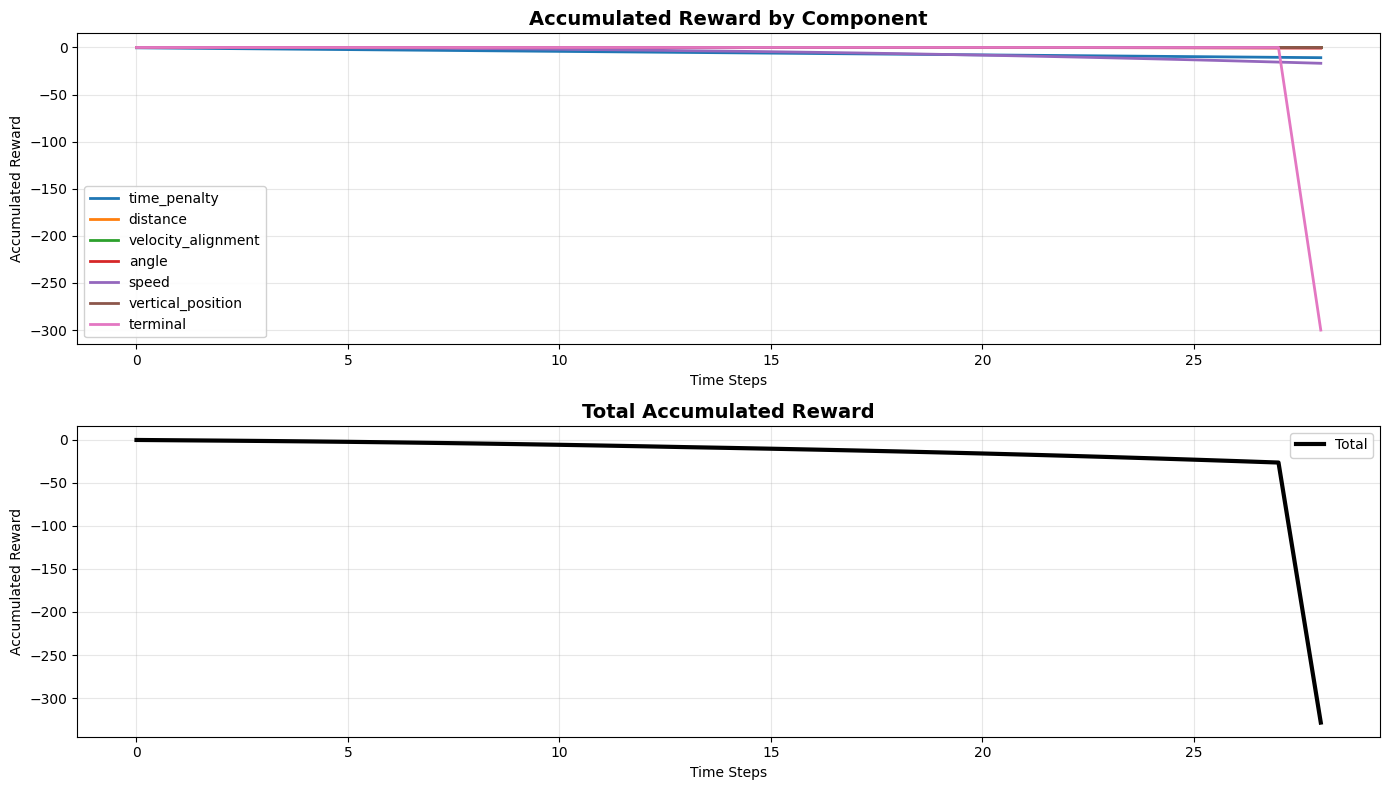

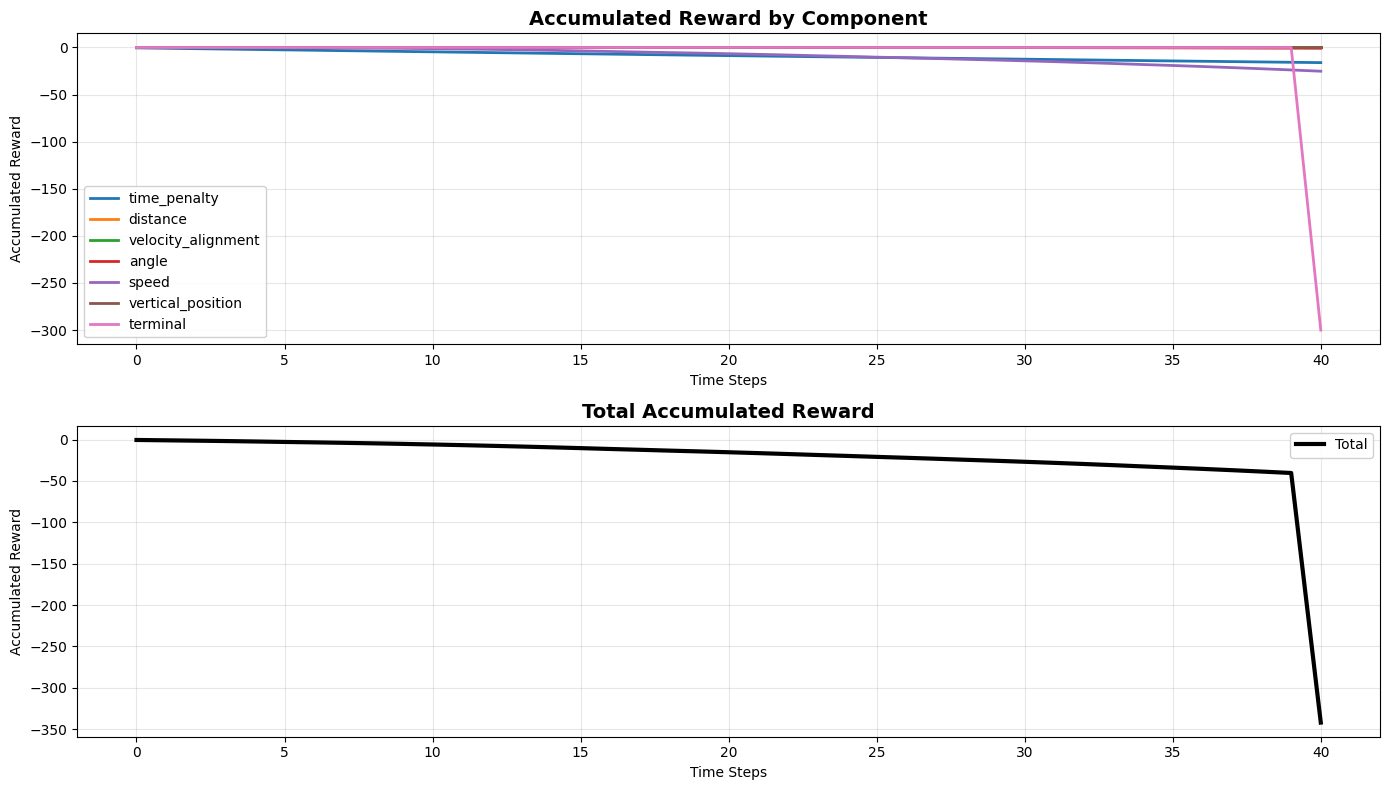

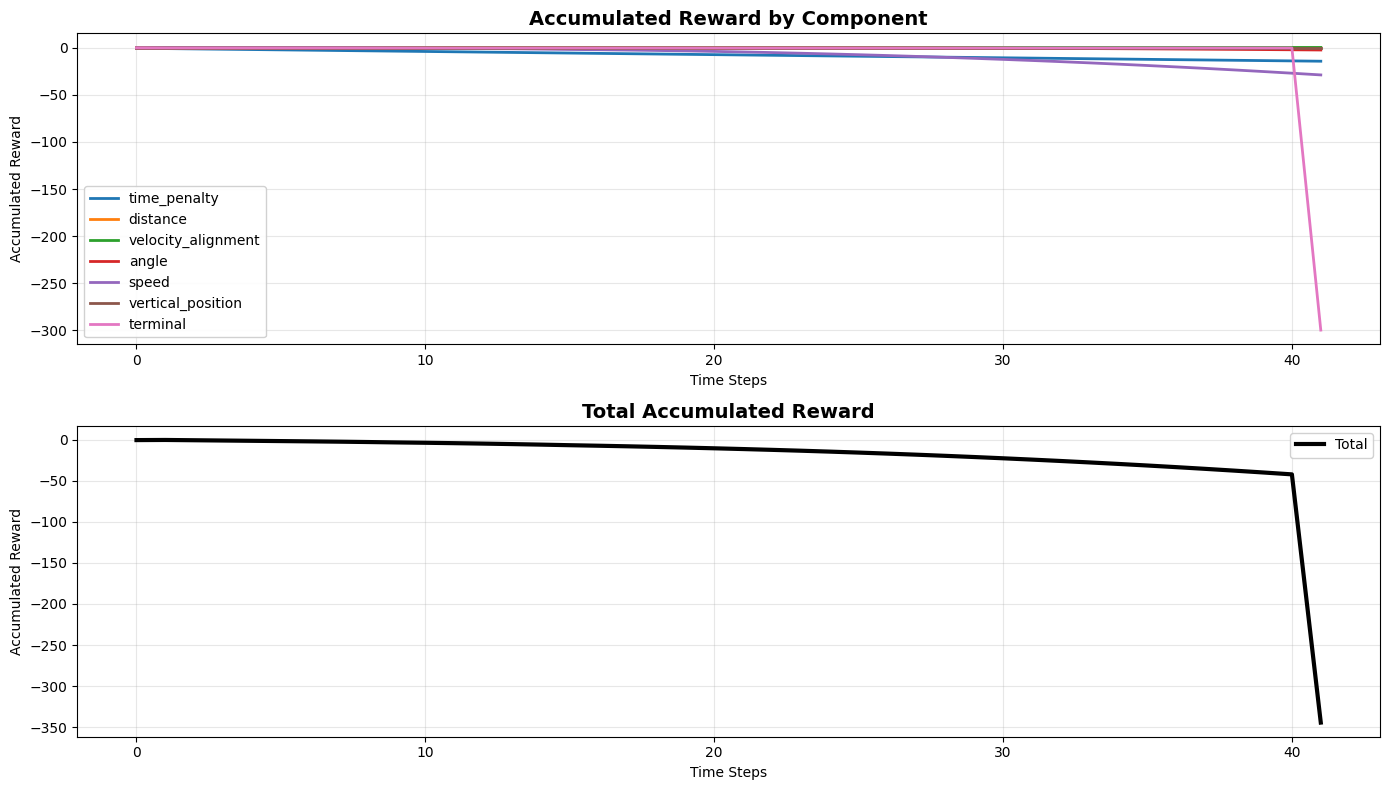

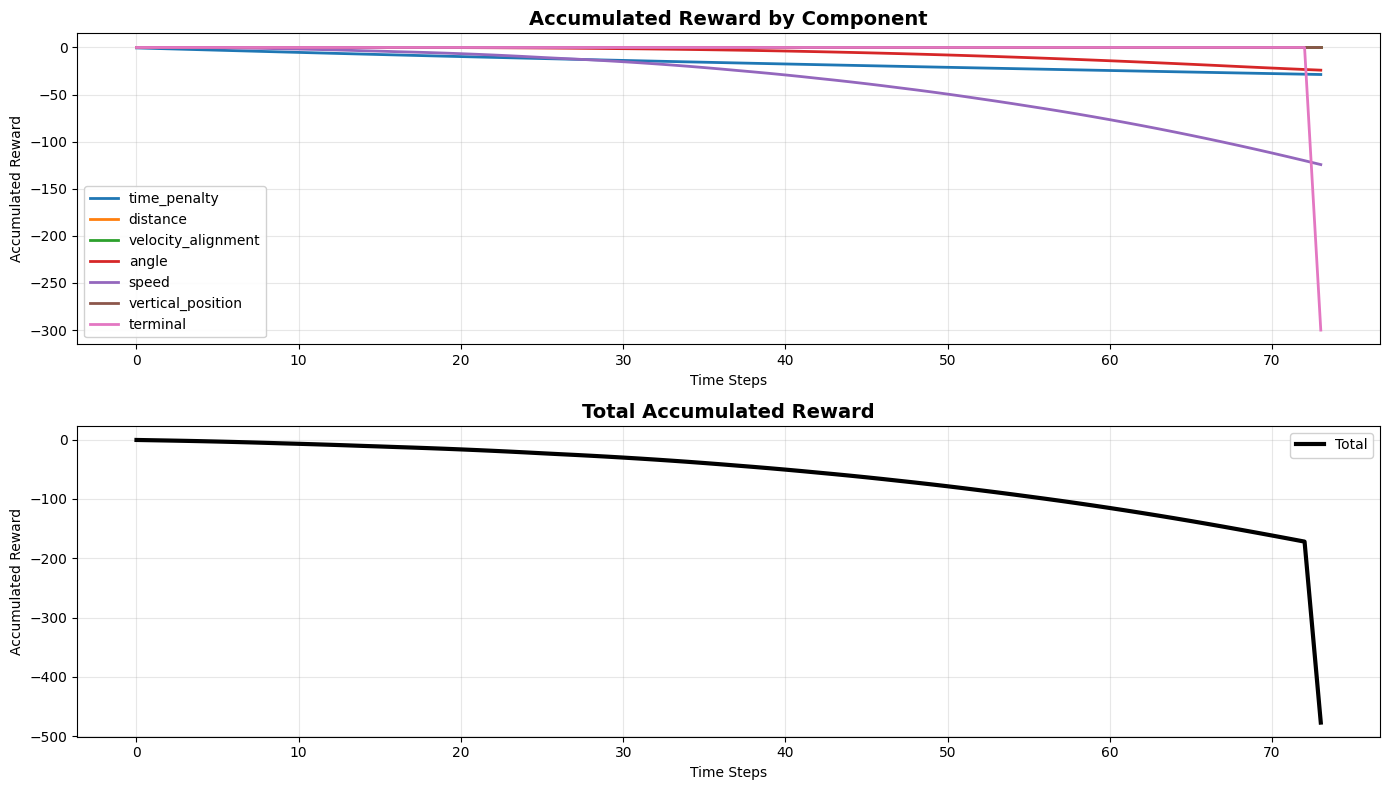

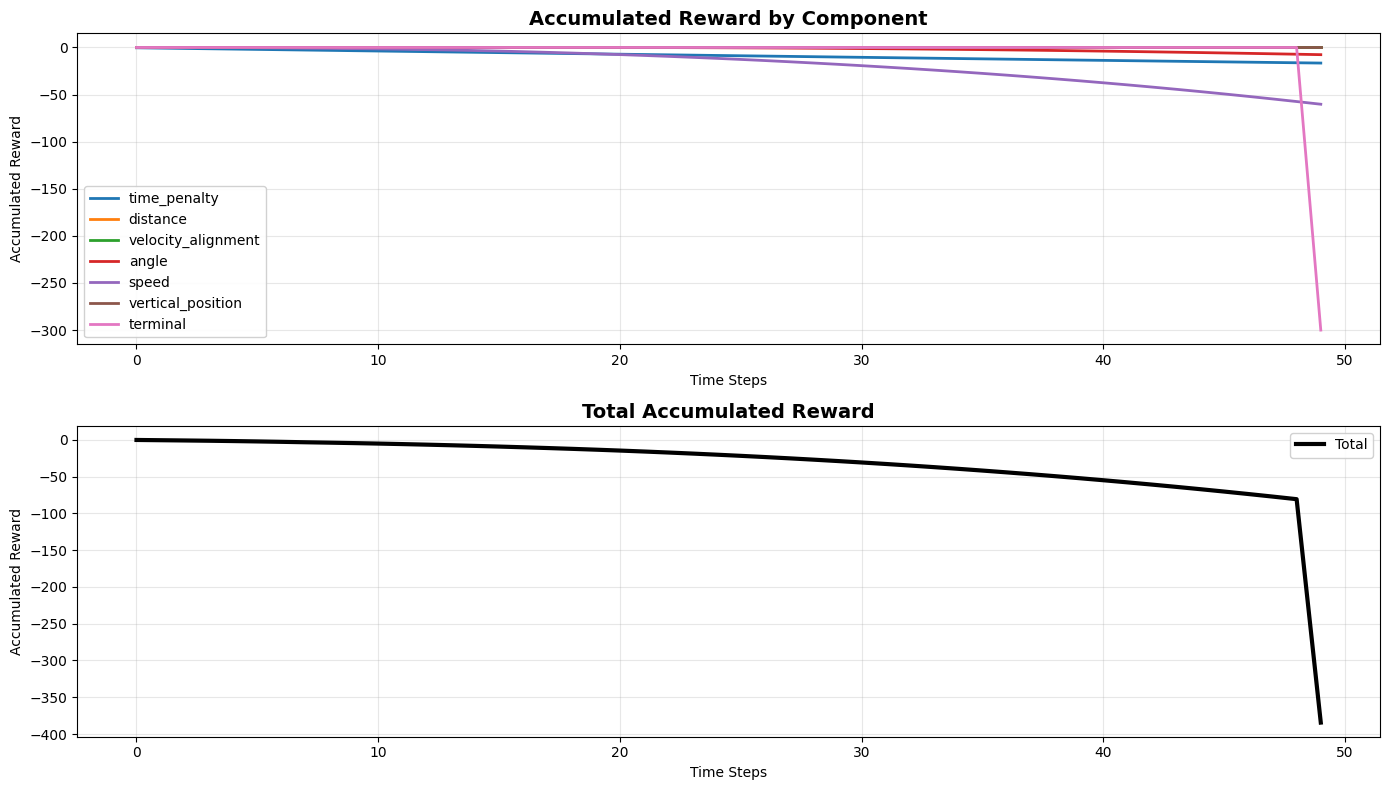

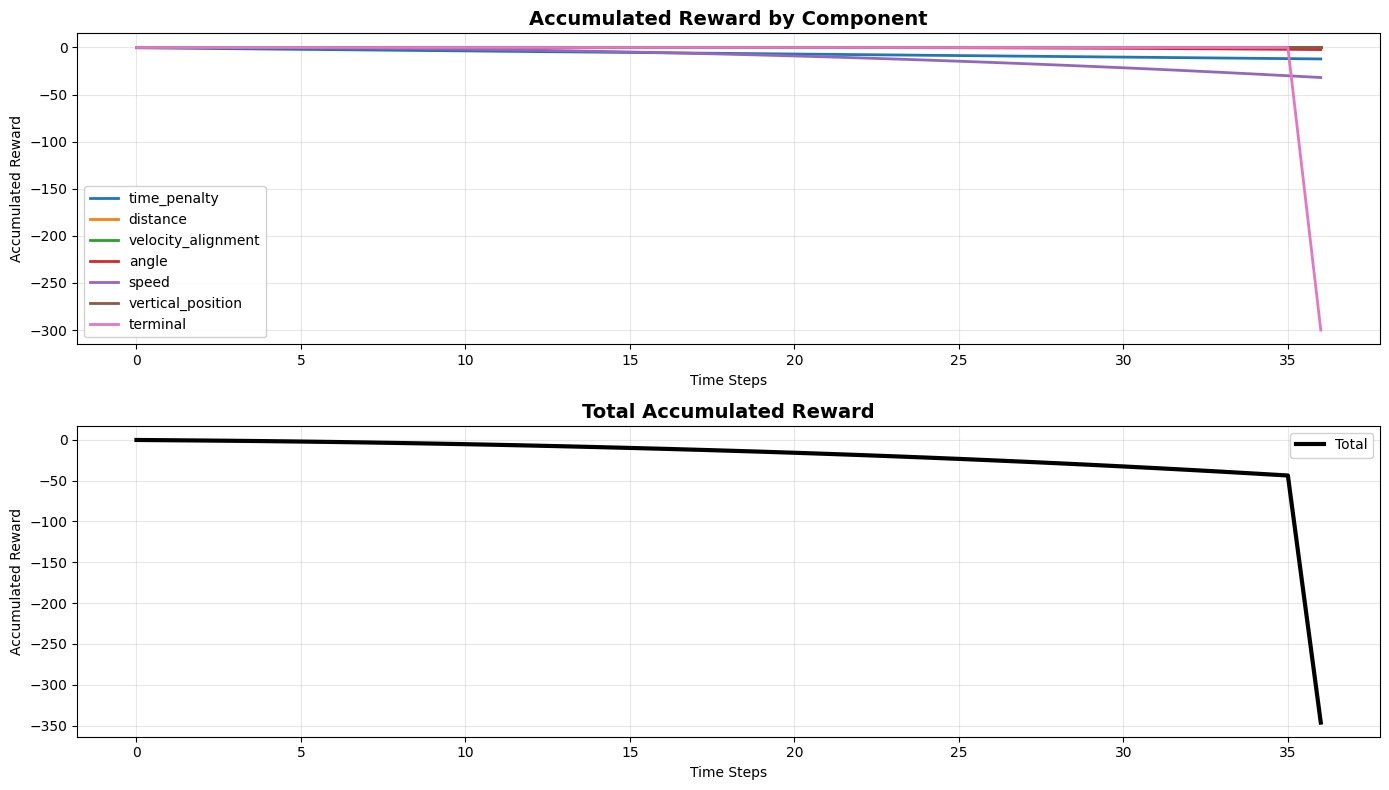

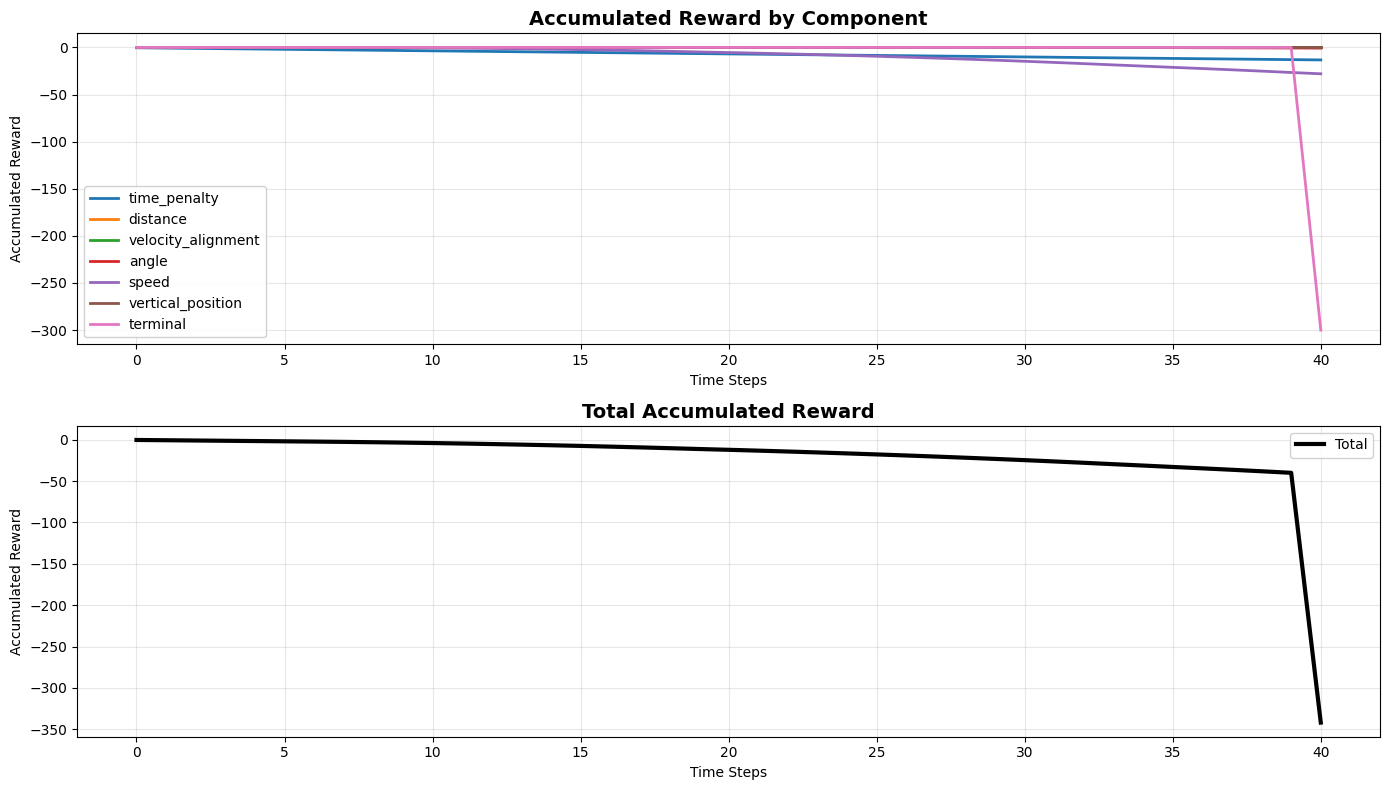

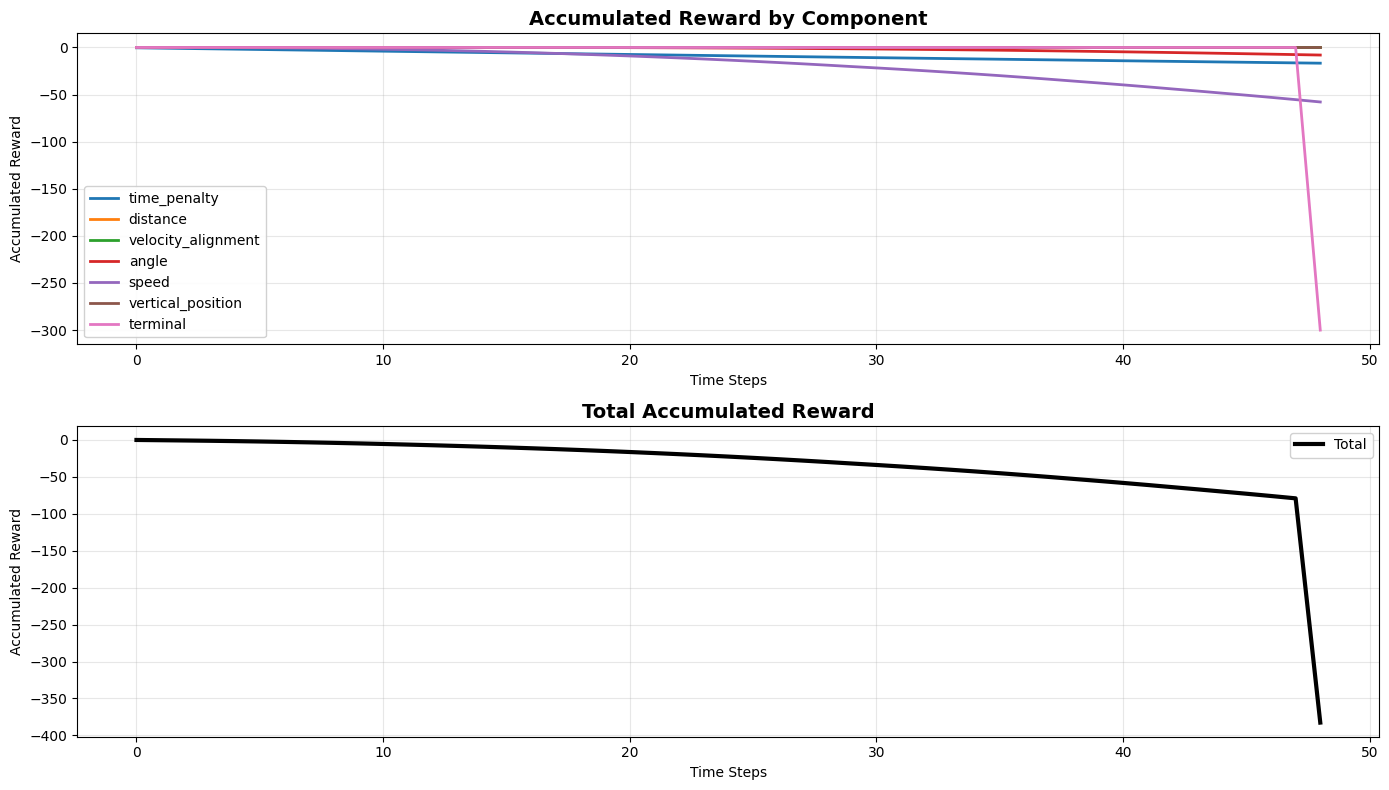

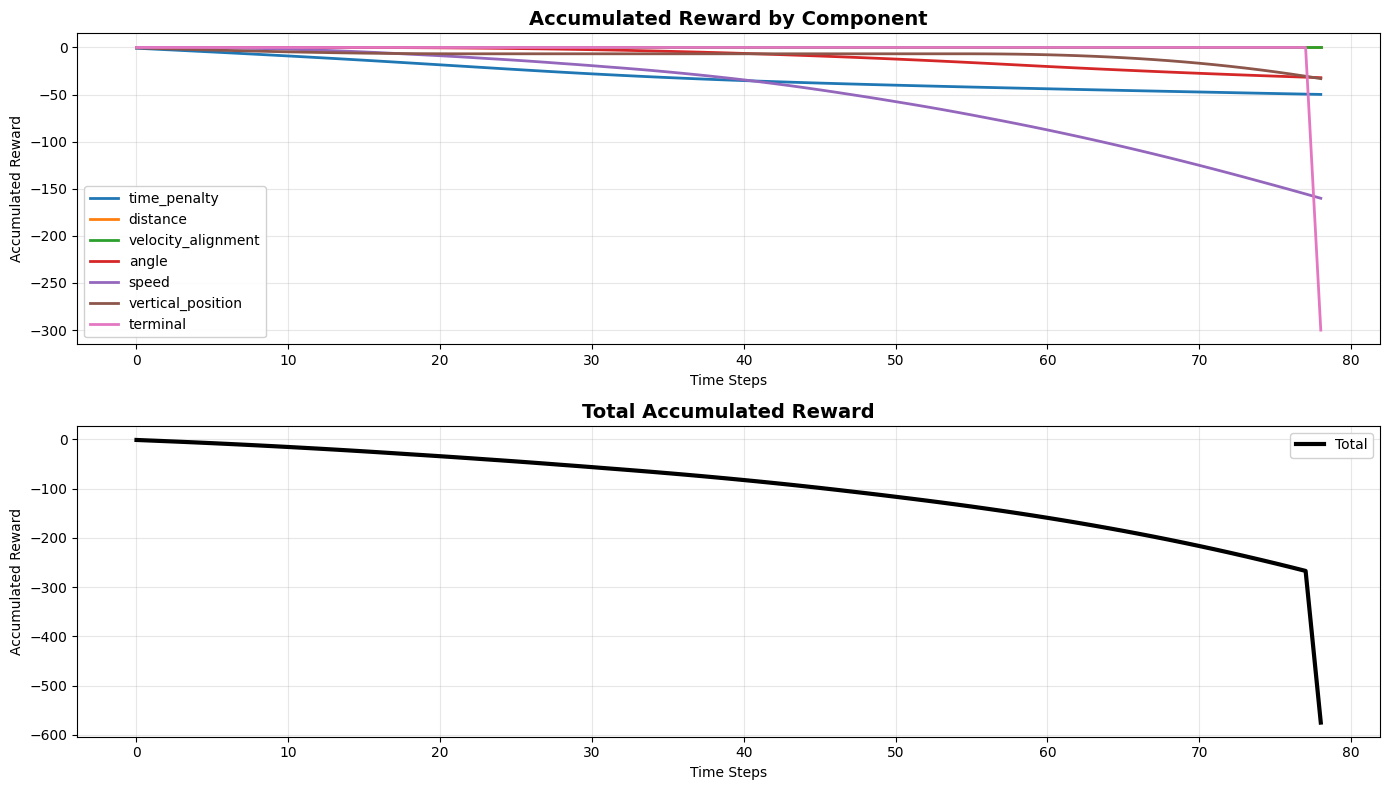

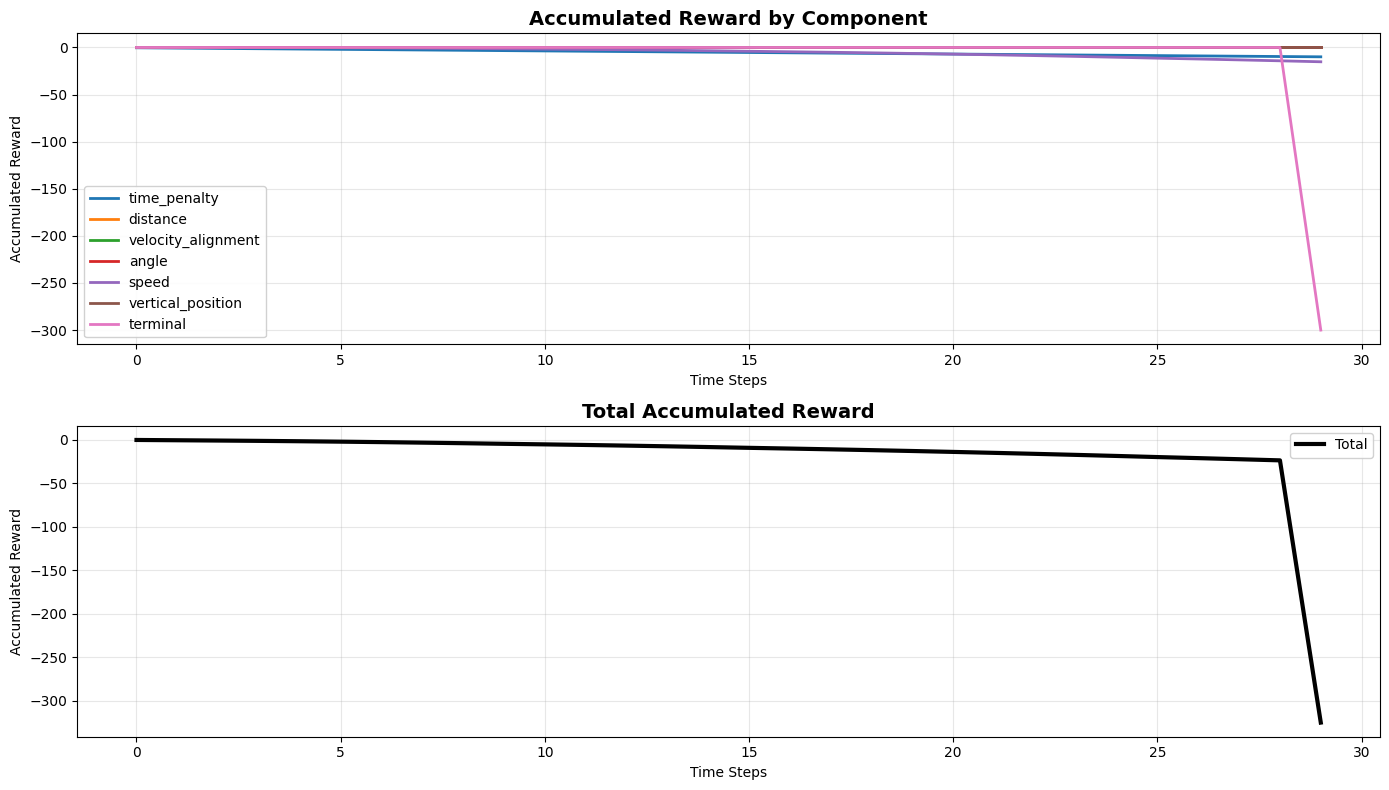

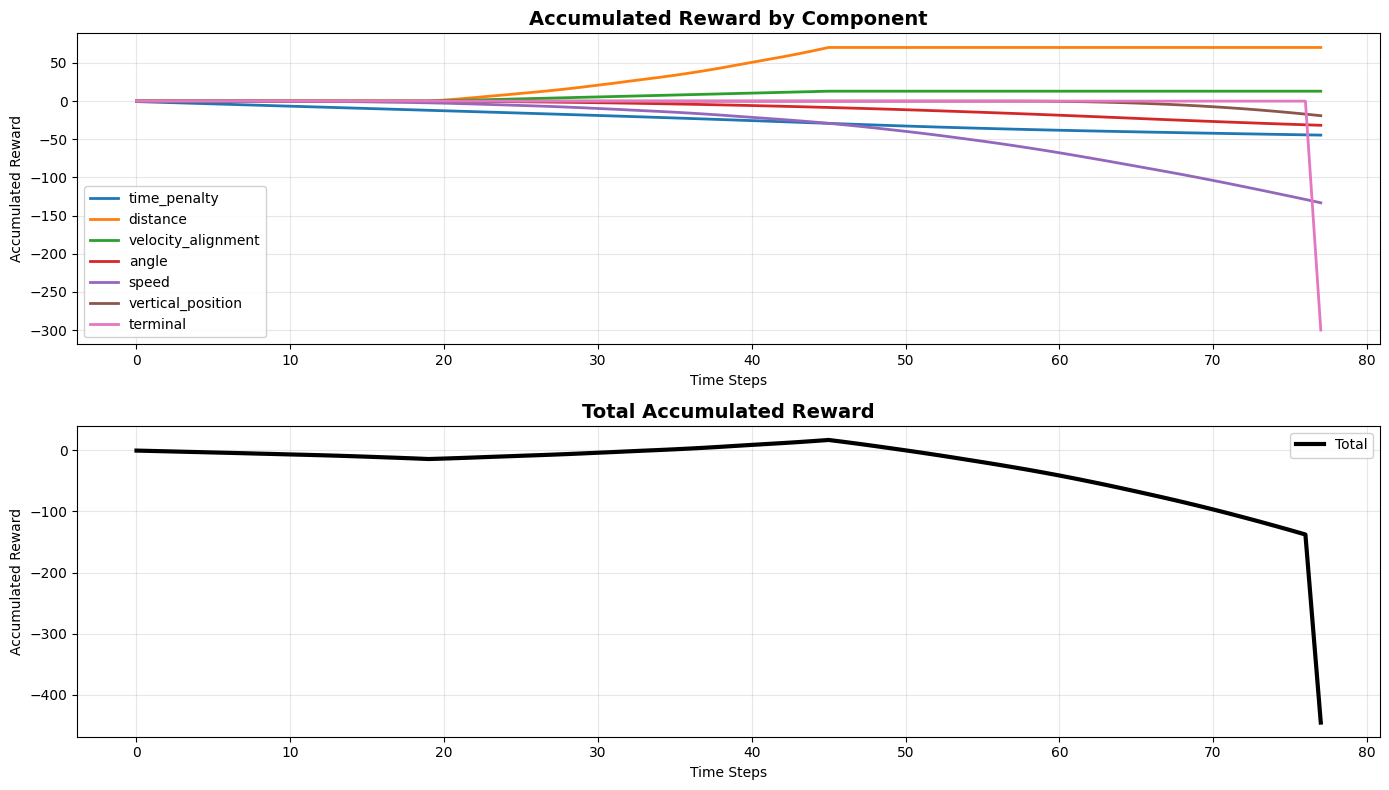

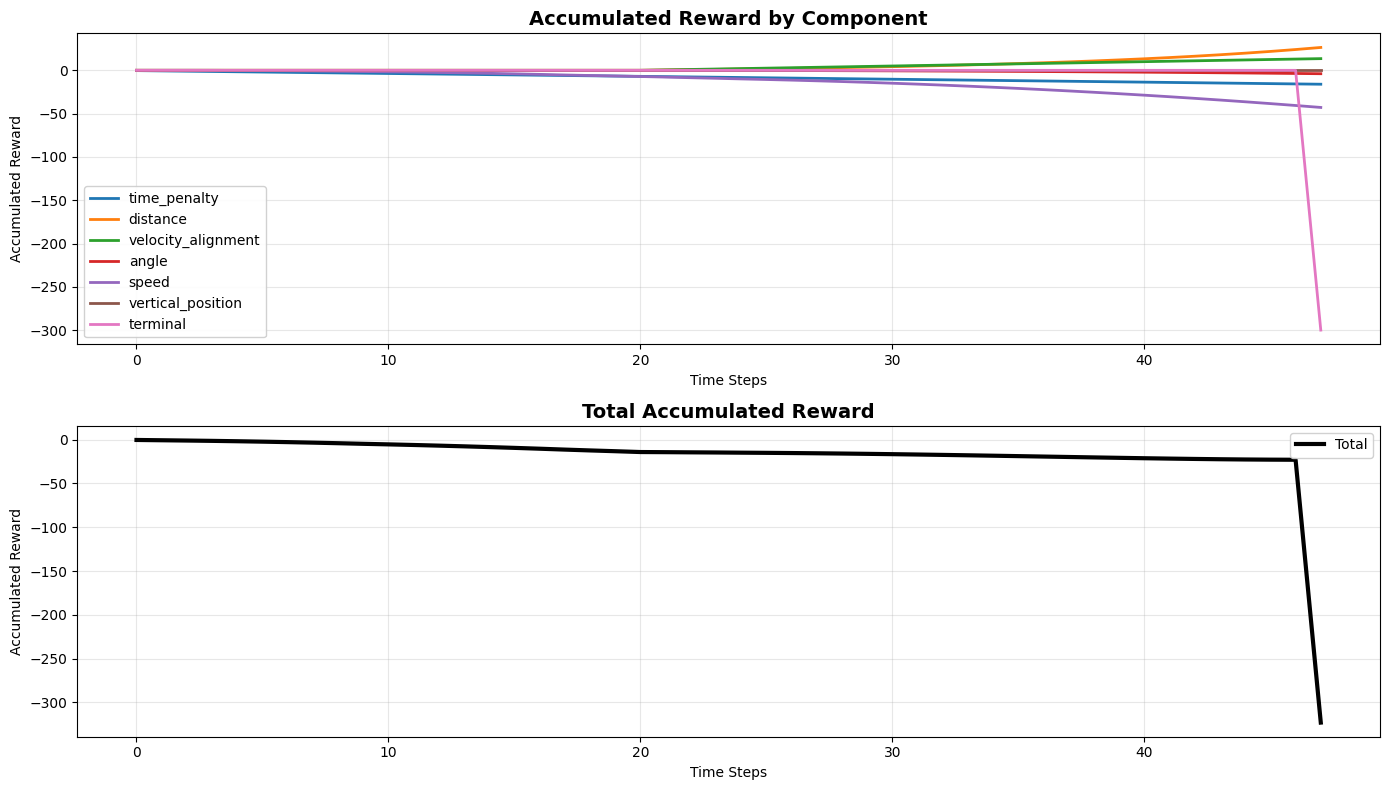

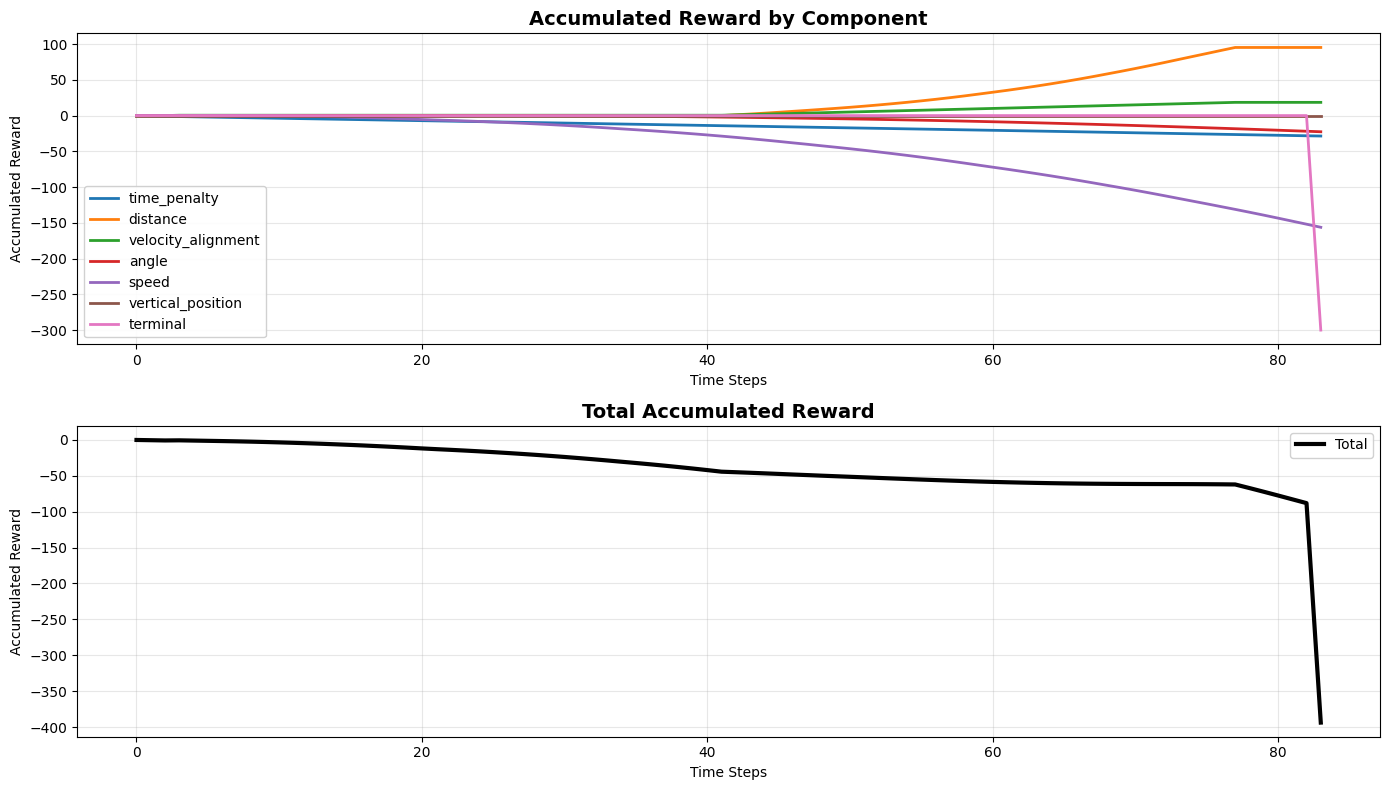

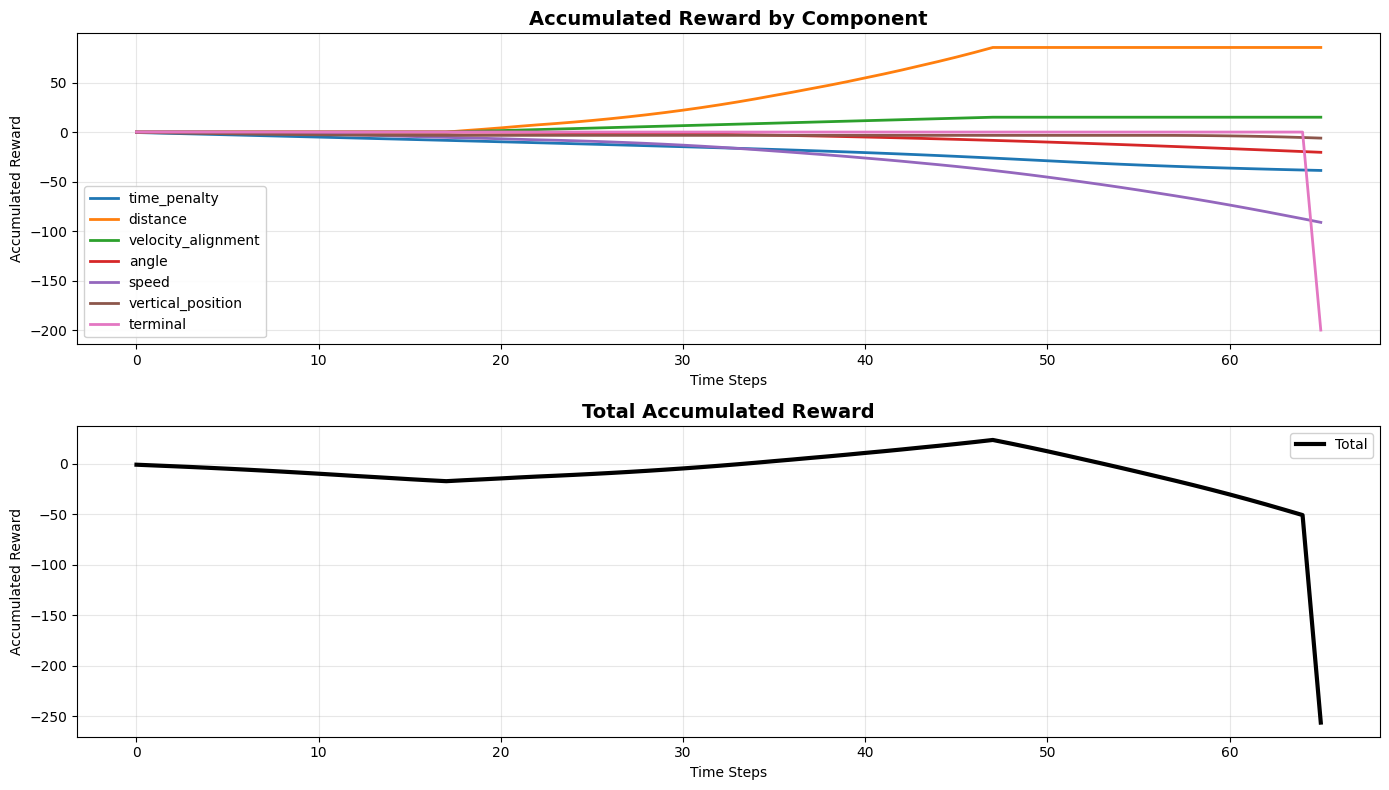

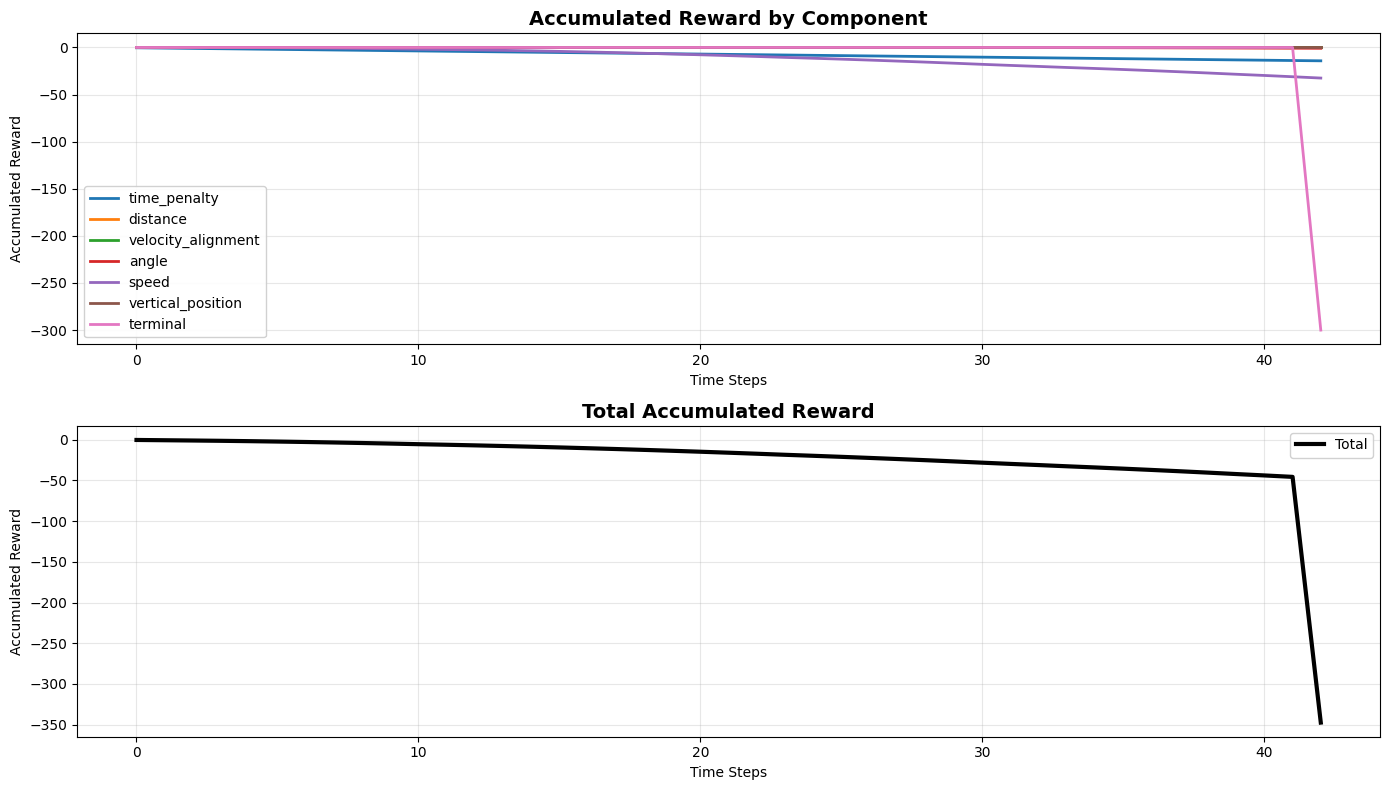

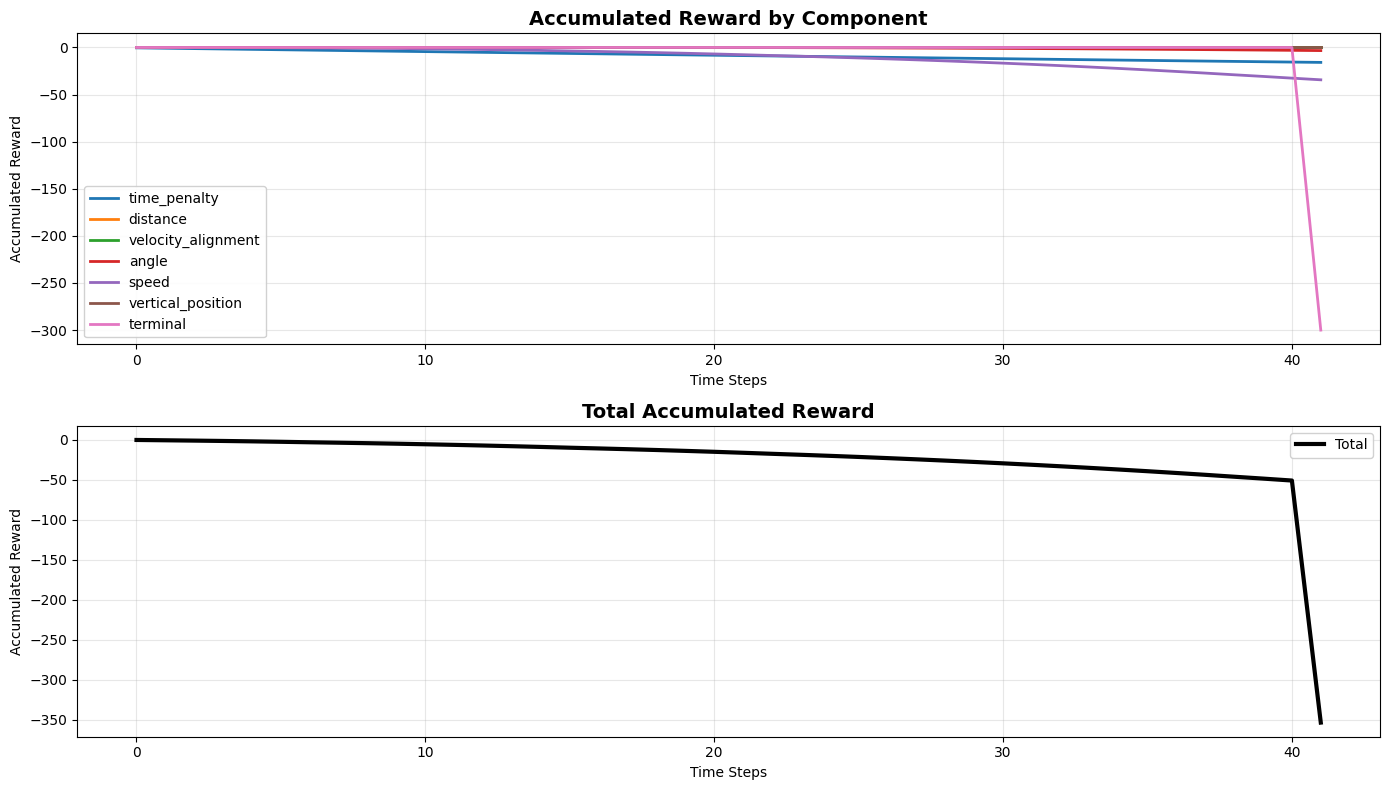

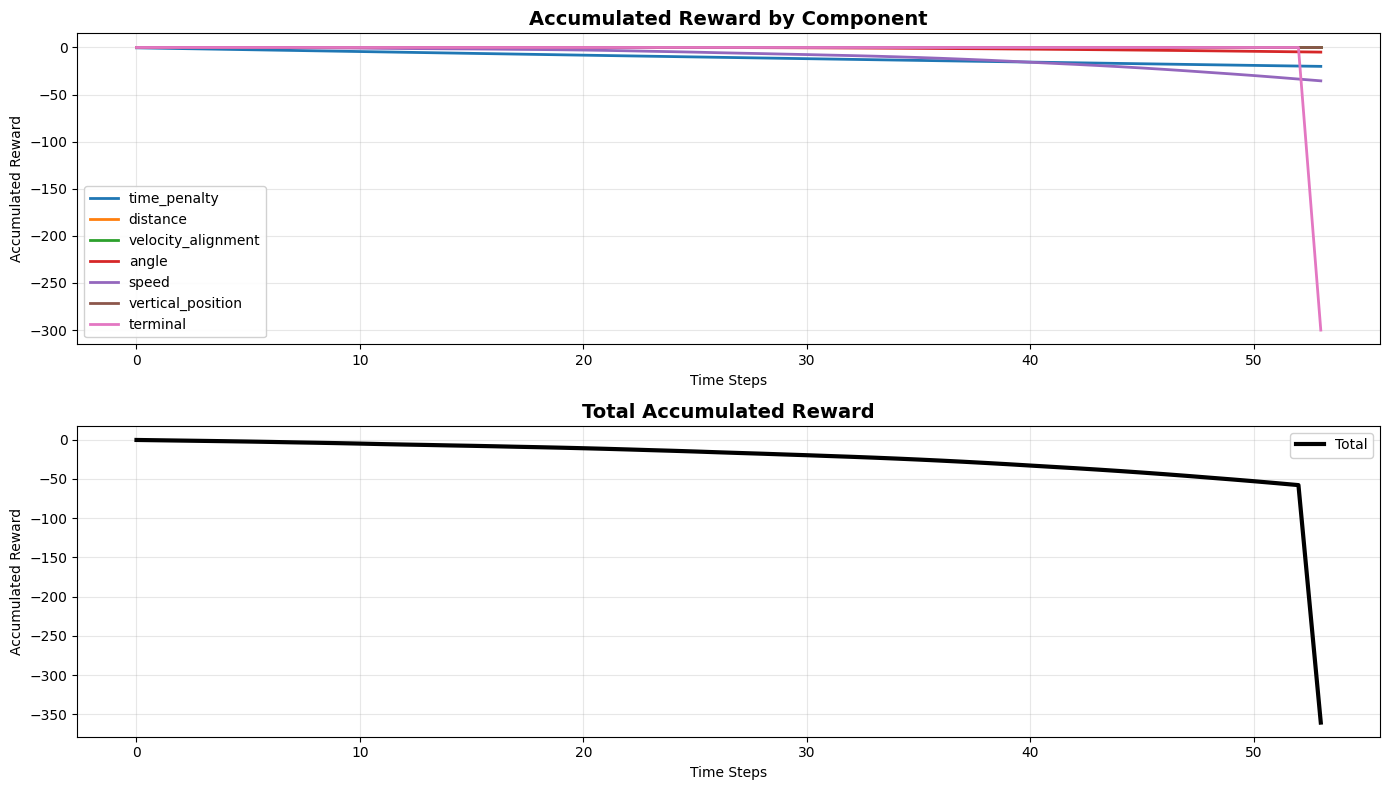

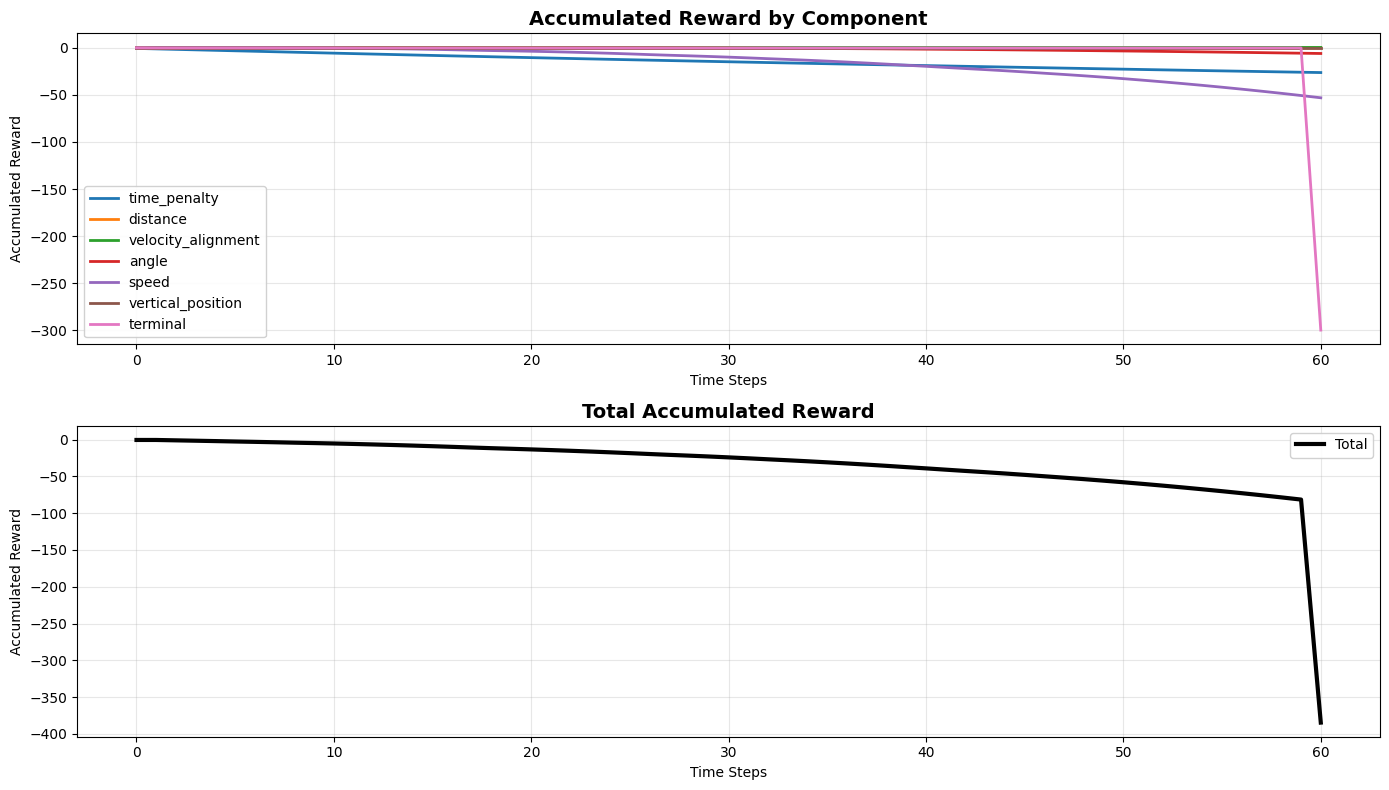

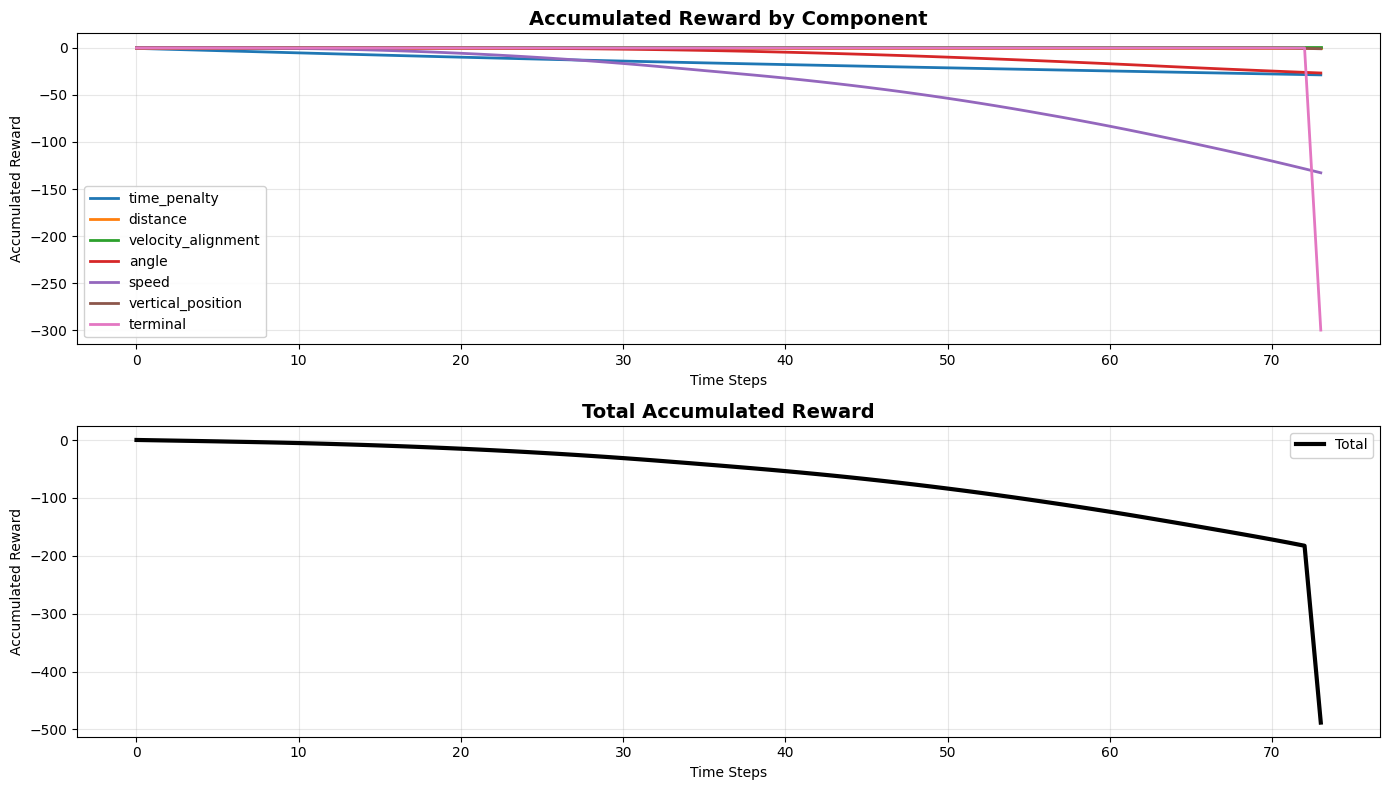

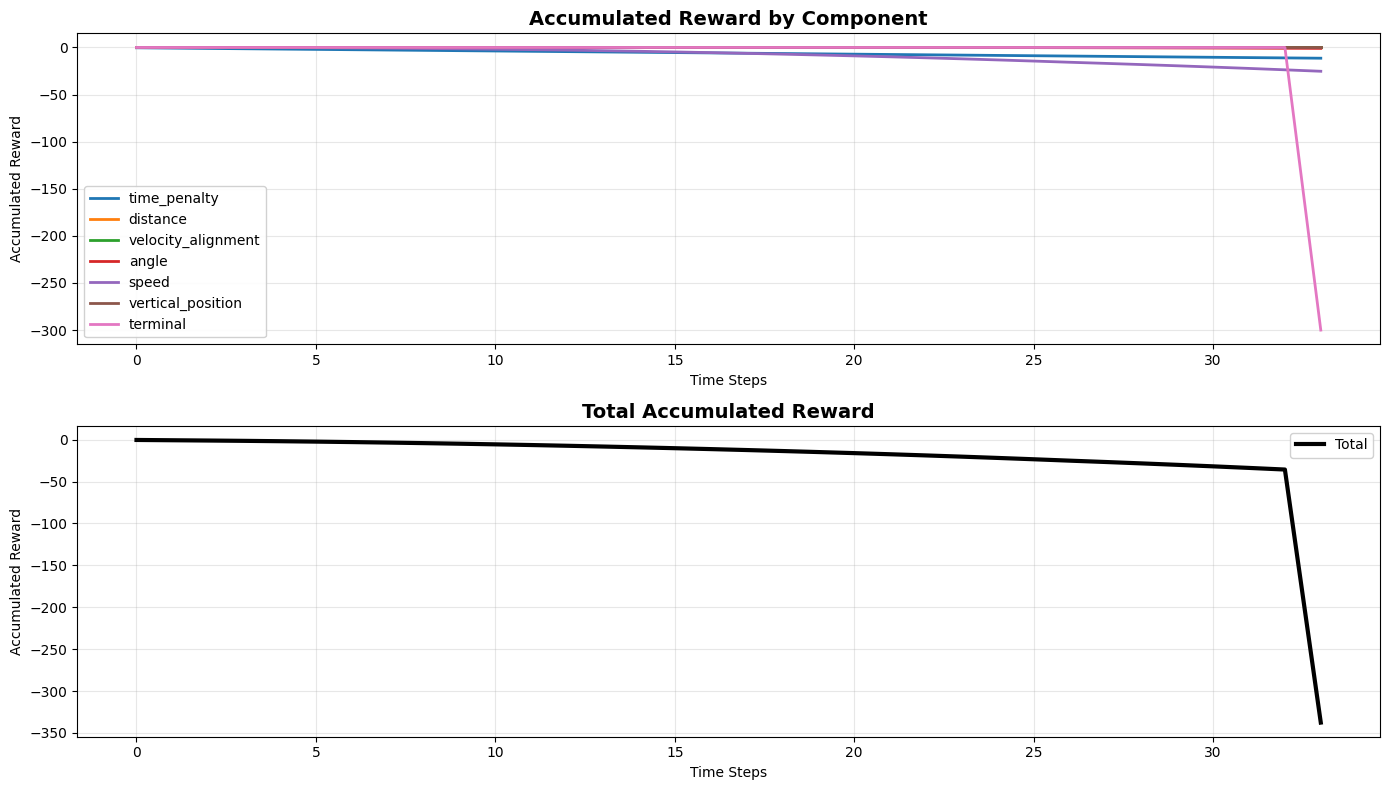

In [12]:
for _ in range(20):
    plot_accumulated_rewards(evaluate_policy(
        client, 
        policy, max_steps=500, temperature=0.2
    ))